In [119]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
%matplotlib inline
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import load_wine
import xgboost as xgb
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from xgboost import plot_importance
from xgboost import XGBClassifier

# 1.初步数据探索

In [120]:

train_data=pd.read_csv("./titanic/train.csv")#相对路径 
test_data=pd.read_csv("./titanic/test.csv")
train_data.head(5)

#查看数据情况 
#pclass为乘客舱等级 SibSp为兄弟姐妹和配偶在船上的人数 Parch为父母或小孩在船上的人数 Ticket为船票号 Fare为票价 Cabin为舱号 Embarked为登船港

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [391]:
train_data.info()
print("------------------------------------------------")
test_data.info()#查看数据量大小和变量数据缺失情况

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   P

In [8]:
train_data.columns.values
test_data.columns.values

array(['PassengerId', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch',
       'Ticket', 'Fare', 'Cabin', 'Embarked'], dtype=object)

In [9]:
#查看数值变量
train_data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [10]:
#查看分类变量
train_data.describe(include="O")#include=o 表示将类型为object的变量纳入

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"Braund, Mr. Owen Harris",male,347082,B96 B98,S
freq,1,577,7,4,644


# 第一步，初步分析结果：
1.数值变量中，总存活率为38%；大多数人在三等舱；年龄在20-40岁之间青壮年较多；有亲人在船上的很少；船票基本都很便宜，有少数极端值 \
2.分类变量中，名字可以提取称呼；男性居多；票号基本不一致，可以删除；船舱有很多缺失值，删除；登录港口有所偏好，大多数在S港口上船 \
3.猜测生存率和舱位，票价，性别，年龄有关，主要归纳为社会地位优势和老弱妇孺两大原因

# 2.相关性分析

In [11]:
#(1) 定性变量和顺序变量 Pclass SibSp Parch sex Embarked  按生存率顺序排序查看是否和生存率相关
train_data[['Pclass', 'Survived']].groupby(['Pclass'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Pclass,Survived
0,1,0.629630
1,2,0.472826
2,3,0.242363


In [13]:
train_data[['SibSp', 'Survived']].groupby(['SibSp'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,SibSp,Survived
1,1,0.535885
2,2,0.464286
0,0,0.345395
3,3,0.250000
4,4,0.166667
5,5,0.000000
6,8,0.000000


In [14]:
train_data[['Parch', 'Survived']].groupby(['Parch'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Parch,Survived
3,3,0.600000
1,1,0.550847
2,2,0.500000
0,0,0.343658
5,5,0.200000
4,4,0.000000
6,6,0.000000


In [16]:
train_data[['Sex', 'Survived']].groupby(['Sex'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Sex,Survived
0,female,0.742038
1,male,0.188908


In [17]:
train_data[['Embarked', 'Survived']].groupby(['Embarked'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Embarked,Survived
0,C,0.553571
1,Q,0.389610
2,S,0.336957


### 定性变量和顺序变量分析结果：
1.舱位跟生存率有关，入模\
2.亲人是否在船上跟生存率没什么关系，与其他变量无关，独立入模\
3.女性存活率显著更高，入模\
4.港口跟生存率关系不明

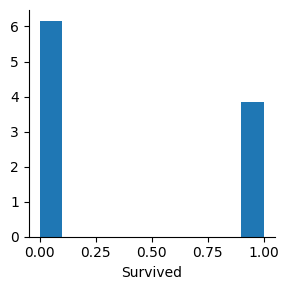

In [32]:
#（2）数值变量 Age Fare 结合Pclass Sex SibSp Parch分析
#直方图可视化呈现
g = sns.FacetGrid(train_data)
g.map(plt.hist, 'Survived',density=True)


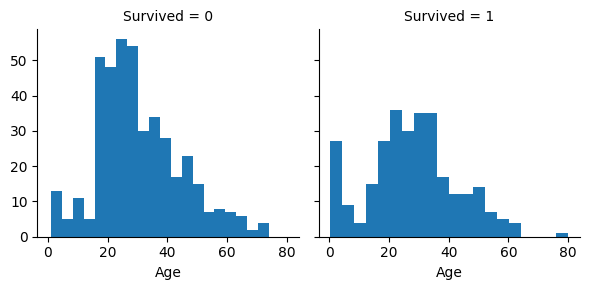

In [21]:

g = sns.FacetGrid(train_data, col='Survived')
g.map(plt.hist, 'Age', bins=20)

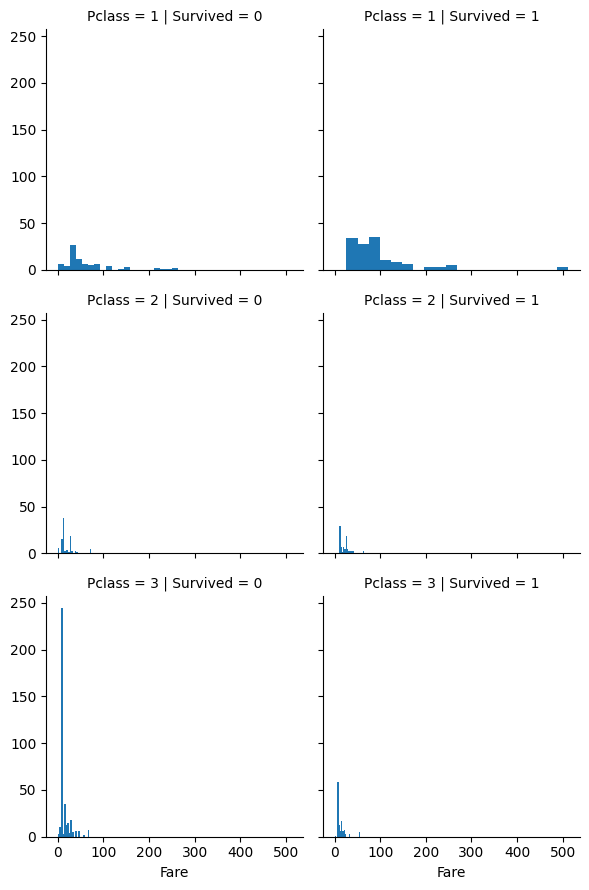

In [23]:
g = sns.FacetGrid(train_data, col='Survived',row="Pclass")
g.map(plt.hist, 'Fare', bins=20)

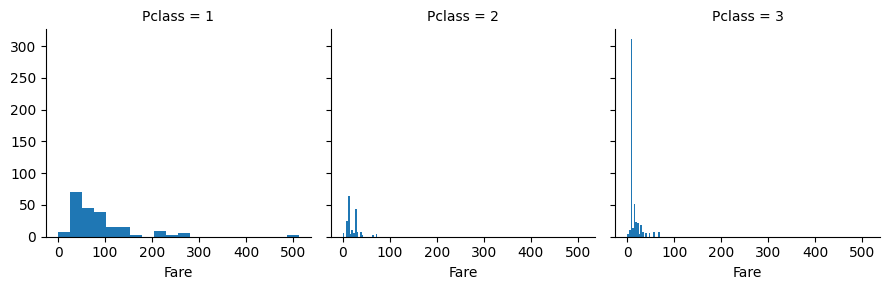

In [274]:
g = sns.FacetGrid(train_data, col='Pclass')
g.map(plt.hist, 'Fare', bins=20)

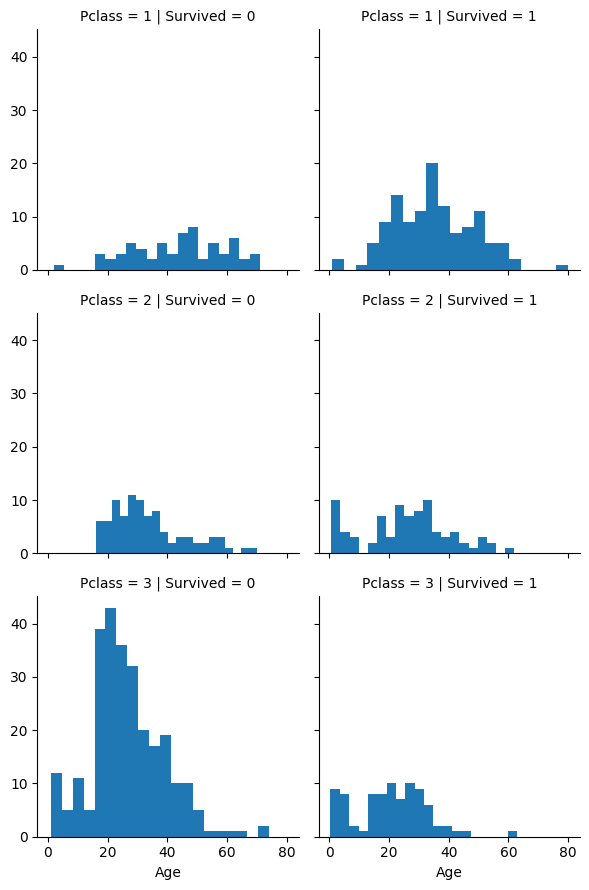

In [24]:
g = sns.FacetGrid(train_data, col='Survived',row="Pclass")
g.map(plt.hist, 'Age', bins=20)

C:\Users\llush\.conda\envs\test1\lib\site-packages\seaborn\axisgrid.py:712: UserWarning: Using the pointplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
C:\Users\llush\.conda\envs\test1\lib\site-packages\seaborn\axisgrid.py:717: UserWarning: Using the pointplot function without specifying `hue_order` is likely to produce an incorrect plot.
  warnings.warn(warning)


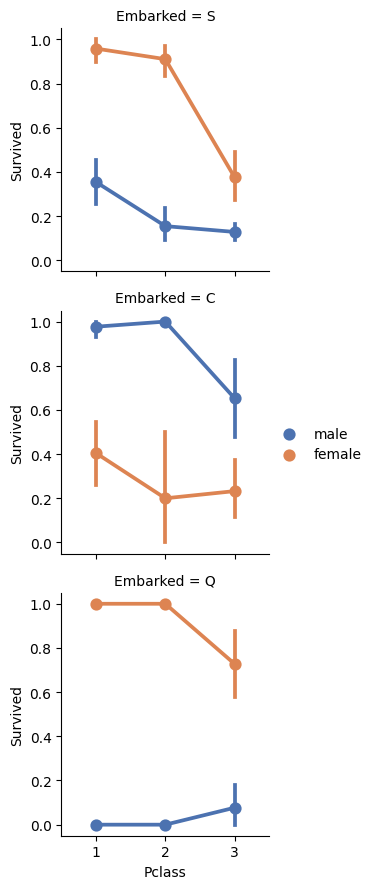

In [27]:
grid = sns.FacetGrid(train_data, row='Embarked')
grid.map(sns.pointplot, 'Pclass', 'Survived', 'Sex', palette='deep')
grid.add_legend()

### 数值变量分析结果：
1.各个年龄生存率不同，但是幸存者年龄分布中小孩和老者数量相较更多，按照舱位划分后小孩幸存更为明显，Age入模\
2.再次印证Pclass有作用，Fare和舱位息息相关，一等舱存活情况乐观不少，Fare入模\
3.不同港口上船生存率不同，男女生存率有差异，因此Embarked也入选


# 3.完善变量，建立新特征

In [121]:
train_data = train_data.drop(['Ticket', 'Cabin'], axis=1)
test_data = test_data.drop(['Ticket', 'Cabin'], axis=1)
combine = [train_data, test_data] #combine之后就能对两个数据集一起处理

In [122]:
for i in combine:
#     i["Title"]=i['Name'].str.extract(r",(.*?). \S")#提取称呼
    i["Title"]=i['Name'].str.extract(", ([A-Za-z]+)\.")

test_data.head(10)


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,892,3,"Kelly, Mr. James",male,34.5,0,0,7.8292,Q,Mr
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,7.0000,S,Mrs
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,9.6875,Q,Mr
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,8.6625,S,Mr
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,12.2875,S,Mrs
5,897,3,"Svensson, Mr. Johan Cervin",male,14.0,0,0,9.2250,S,Mr
6,898,3,"Connolly, Miss. Kate",female,30.0,0,0,7.6292,Q,Miss
7,899,2,"Caldwell, Mr. Albert Francis",male,26.0,1,1,29.0000,S,Mr
8,900,3,"Abrahim, Mrs. Joseph (Sophie Halaut Easu)",female,18.0,0,0,7.2292,C,Mrs
9,901,3,"Davies, Mr. John Samuel",male,21.0,2,0,24.1500,S,Mr


In [123]:
train_data[pd.isnull(train_data["Title"])] #查看是否有没有匹配上的

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,Title
759,760,1,1,"Rothes, the Countess. of (Lucy Noel Martha Dye...",female,33.0,0,0,86.5,S,NaN


In [124]:
pd.crosstab(train_data['Title'], train_data['Sex'])#区分男女
#分为Master Miss Mrs Mr Other

Sex,female,male
Title,,
Capt,0,1
Col,0,2
Don,0,1
Dr,1,6
Jonkheer,0,1
Lady,1,0
Major,0,2
Master,0,40
Miss,182,0


In [125]:

for i in combine:
    i['Title']=i['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'],'Other')
    i['Title']=i['Title'].replace('Mlle', 'Miss')
    i['Title']=i['Title'].replace('Ms', 'Miss')
    i['Title']=i['Title'].replace('Mme', 'Mrs')
    


In [126]:
test_data.tail(10)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,Title
408,1300,3,"Riordan, Miss. Johanna Hannah""""",female,NaN,0,0,7.7208,Q,Miss
409,1301,3,"Peacock, Miss. Treasteall",female,3.0,1,1,13.7750,S,Miss
410,1302,3,"Naughton, Miss. Hannah",female,NaN,0,0,7.7500,Q,Miss
411,1303,1,"Minahan, Mrs. William Edward (Lillian E Thorpe)",female,37.0,1,0,90.0000,Q,Mrs
412,1304,3,"Henriksson, Miss. Jenny Lovisa",female,28.0,0,0,7.7750,S,Miss
413,1305,3,"Spector, Mr. Woolf",male,NaN,0,0,8.0500,S,Mr
414,1306,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,108.9000,C,Other
415,1307,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,7.2500,S,Mr
416,1308,3,"Ware, Mr. Frederick",male,NaN,0,0,8.0500,S,Mr
417,1309,3,"Peter, Master. Michael J",male,NaN,1,1,22.3583,C,Master


In [127]:
train_data[["Title","Survived"]].groupby(["Title"],as_index=False).mean().sort_values(by='Survived', ascending=False)

,Title,Survived
3,Mrs,0.793651
1,Miss,0.702703
0,Master,0.575000
4,Other,0.318182
2,Mr,0.156673


In [128]:
title_map = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Other": 5}
for i in combine:
    i['Title'] = i['Title'].map(title_map)
    i['Title'] = i['Title'].fillna(0)
train_data.info()
print("------------------------------------------------------------")
test_data.info()
test_data.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Fare         891 non-null    float64
 9   Embarked     889 non-null    object 
 10  Title        891 non-null    float64
dtypes: float64(3), int64(5), object(3)
memory usage: 76.7+ KB
------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    in

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,892,3,"Kelly, Mr. James",male,34.5,0,0,7.8292,Q,1
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,7.0000,S,3
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,9.6875,Q,1
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,8.6625,S,1
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,12.2875,S,3
5,897,3,"Svensson, Mr. Johan Cervin",male,14.0,0,0,9.2250,S,1
6,898,3,"Connolly, Miss. Kate",female,30.0,0,0,7.6292,Q,2
7,899,2,"Caldwell, Mr. Albert Francis",male,26.0,1,1,29.0000,S,1
8,900,3,"Abrahim, Mrs. Joseph (Sophie Halaut Easu)",female,18.0,0,0,7.2292,C,3
9,901,3,"Davies, Mr. John Samuel",male,21.0,2,0,24.1500,S,1


In [129]:
#补全年龄 根据称谓的变量补全年龄 和原文不一样 看看哪样补全更准
list_train=train_data[["Title","Age"]].groupby(["Title"],as_index=False).mean()
list_test=test_data[["Title","Age"]].groupby(["Title"],as_index=False).mean()
np.array(list_test)

array([[ 1.        , 32.        ],
       [ 2.        , 21.77484375],
       [ 3.        , 38.90322581],
       [ 4.        ,  7.40647059],
       [ 5.        , 43.83333333]])

In [130]:
# print(train_data[train_data["Title"]==4])
for i in range(1,6):
    train_data.loc[(train_data.Age.isnull())&(train_data.Title==i),"Age"]=np.array(list_train)[i-1,1]   
    test_data.loc[(test_data.Age.isnull())&(test_data.Title==i),"Age"]=np.array(list_test)[i-1,1] 
# train_data.head(50)
train_data.info()
print("-----------------------------------------------------")
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          891 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Fare         891 non-null    float64
 9   Embarked     889 non-null    object 
 10  Title        891 non-null    float64
dtypes: float64(3), int64(5), object(3)
memory usage: 76.7+ KB
-----------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 

In [131]:
train_data.Embarked.mode()[0]#找到embarked众数

'S'

In [132]:
mean_Fare=np.array(test_data[["Pclass","Fare"]].groupby(["Pclass"],as_index=False).mean())
mean_Fare

array([[ 1.        , 94.2802972 ],
       [ 2.        , 22.2021043 ],
       [ 3.        , 12.45967788]])

In [133]:
#下一步补全embarked和fare
train_data["Embarked"].fillna(train_data.Embarked.mode()[0],inplace=True)#记得加inplace参数
for i in range(1,4):
    test_data.loc[(test_data.Fare.isnull())&(test_data["Pclass"]==i),"Fare"]=mean_Fare[i-1,1]
test_data[test_data["Age"]==60.5]#检验

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,Title
152,1044,3,"Storey, Mr. Thomas",male,60.5,0,0,12.459678,S,1


In [134]:
#缺失值到此complete
train_data.info()
print("----------------------------------")
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          891 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Fare         891 non-null    float64
 9   Embarked     891 non-null    object 
 10  Title        891 non-null    float64
dtypes: float64(3), int64(5), object(3)
memory usage: 76.7+ KB
----------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       41

In [135]:
sex_map={"male":0,"female":1}
embark_map={"S":1,"Q":2,"C":3}
for i in combine:
    i["Sex"]=i["Sex"].map(sex_map)
    i["Embarked"]=i["Embarked"].map(embark_map)
    i["Familyab"]=i["SibSp"]+i["Parch"]
    i.loc[i["Familyab"]==0,"Isalone"]=1
    i.loc[i["Familyab"]!=0,"Isalone"]=0
#     i.drop(columns=["PassengerId","Name","SibSp","Parch"],inplace=True)
    
train_data.drop(columns=["PassengerId","Name"],inplace=True)
# train_data.drop(columns=["PassengerId","Name","SibSp","Parch"],inplace=True)
test_data1=test_data.copy()
test_data.drop(columns=["PassengerId","Name"],inplace=True)
# test_data.drop(columns=["PassengerId","Name","SibSp","Parch"],inplace=True)
test_data.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title,Familyab,Isalone
0,3,0,34.5,0,0,7.8292,2,1,0,1.0
1,3,1,47.0,1,0,7.0000,1,3,1,0.0
2,2,0,62.0,0,0,9.6875,2,1,0,1.0
3,3,0,27.0,0,0,8.6625,1,1,0,1.0
4,3,1,22.0,1,1,12.2875,1,3,2,0.0


# 特征基本构建完毕
1.根据姓名构建title，发现生存率各异，入模，删掉姓名\
2.补充年龄缺失值，根据相应title的平均年龄填补\
3.补充embarked用众数，因为仅缺失一个值\
4.补充fare用舱等级对应平均fare补充，因为船票价格跟舱等级相关性高

# 4.建立模型 


In [137]:
#首先划分验证集 训练集与验证集化为8：2
train_val_y=train_data["Survived"]
train_data.drop(columns="Survived",inplace=True)


In [138]:
#首先划分验证集 训练集与验证集化为8：2
x_train, x_val, y_train, y_val = train_test_split(train_data, train_val_y, test_size = 0.2, random_state = 42)


# （1）随机森林
最终test准确度为0.77

In [47]:
clf = DecisionTreeClassifier(random_state=0)
rfc = RandomForestClassifier(n_estimators=100,random_state=0)
clf = clf.fit(x_train,y_train)
rfc = rfc.fit(x_train,y_train)
score_c = clf.score(x_val,y_val)
score_r = rfc.score(x_val,y_val)
print("Single Tree:{}".format(score_c),"Random Forest:{}".format(score_r))
#发现随机森林的准确度更高

Single Tree:0.7821229050279329 Random Forest:0.8379888268156425


val最大得分：0.8069612704789405 子树数量为：121


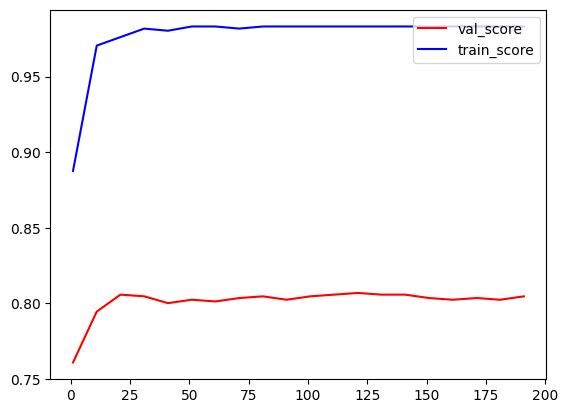

In [77]:
# 调参，绘制学习曲线来调参n_estimators（对随机森林影响最大）
score_lt = []
score_train=[]
# 每隔10步建立一个随机森林，获得不同n_estimators的得分
for i in range(0,200,10):
    rfc = RandomForestClassifier(n_estimators=i+1,random_state=0)
    rfc = rfc.fit(x_train,y_train)
    score1=rfc.score(x_train,y_train)
    score = cross_val_score(rfc, train_data,train_val_y, cv=5,scoring='accuracy').mean()#5折交叉验证 此处用全部的数据
    score_lt.append(score)
    score_train.append(score1)
score_max = max(score_lt)
print('val最大得分：{}'.format(score_max),
      '子树数量为：{}'.format(score_lt.index(score_max)*10+1))

# 绘制学习曲线
x = np.arange(1,201,10)
plt.plot(x, score_lt, 'r', label="val_score")
plt.plot(x, score_train, 'b', label="train_score")
plt.legend(loc="upper right")
plt.show()
#在121左右最优，继续寻参

val最大得分：0.8069675475488042 子树数量为：112


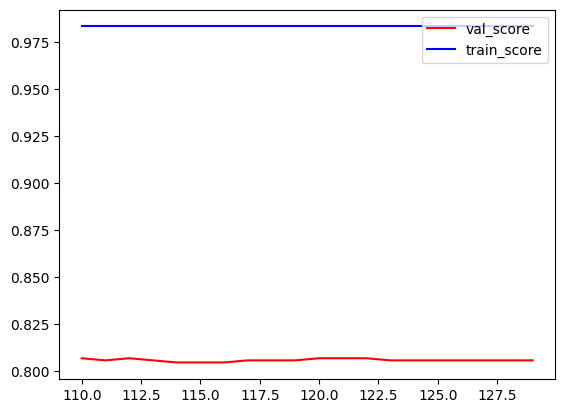

In [78]:
# n_estimators范围为110-129
score_lt = []
score_train=[]
# 每隔10步建立一个随机森林，获得不同n_estimators的得分
for i in range(110,130):
    rfc = RandomForestClassifier(n_estimators=i,random_state=0)
    rfc = rfc.fit(x_train,y_train)
    score1=rfc.score(x_train,y_train)
    score = cross_val_score(rfc, train_data,train_val_y, cv=5,scoring='accuracy').mean()#5折交叉验证 此处用全部的数据
    score_lt.append(score)
    score_train.append(score1)
score_max = max(score_lt)
print('val最大得分：{}'.format(score_max),
      '子树数量为：{}'.format(score_lt.index(score_max)+110))

# 绘制学习曲线
x = np.arange(110,130)
plt.plot(x, score_lt, 'r', label="val_score")
plt.plot(x, score_train, 'b', label="train_score")
plt.legend(loc="upper right")
plt.show()
#子树数最多为112

In [79]:
#针对过拟合问题，调小模型复杂度 网格搜索寻优（本质是穷举法）
# 建立n_estimators为28的随机森林
rfc = RandomForestClassifier(n_estimators=112, random_state=0)

# 用网格搜索调整max_depth
param_grid = {'max_depth':np.arange(1,20)}
GS = GridSearchCV(rfc, param_grid, cv=5)
GS.fit(train_data, train_val_y)

best_param = GS.best_params_
best_score = GS.best_score_
print(best_param, best_score)
#找到最优max_depth=5 简化模型有利于泛化效果 因此继续简化

{'max_depth': 5} 0.8328080370333891


In [71]:
train_data.shape

(891, 10)

In [81]:
# 用网格搜索调整max_features
rfc = RandomForestClassifier(n_estimators=112,max_depth=5,random_state=0)
param_grid = {'max_features':np.arange(1,11)}
GS = GridSearchCV(rfc, param_grid, cv=5)
GS.fit(train_data, train_val_y)

best_param = GS.best_params_
best_score = GS.best_score_
print(best_param, best_score) 
#max_features=6时最优

{'max_features': 6} 0.828278199736363


In [83]:
# 用网格搜索调整min_samples_leaf
rfc = RandomForestClassifier(n_estimators=112,max_depth=5,max_features=6,random_state=0)
param_grid = {'min_samples_leaf':np.arange(1,11)}
GS = GridSearchCV(rfc, param_grid, cv=5)
GS.fit(train_data, train_val_y)

best_param = GS.best_params_
best_score = GS.best_score_
print(best_param, best_score) 
#min_samples_leaf=4时最优

{'min_samples_leaf': 3} 0.8282844768062269


In [84]:
# 用网格搜索调整min_samples_split
rfc = RandomForestClassifier(n_estimators=112,max_depth=5,max_features=6,min_samples_leaf=3,random_state=0)
param_grid = {'min_samples_split':np.arange(1,21)}
GS = GridSearchCV(rfc, param_grid, cv=5)
GS.fit(train_data, train_val_y)

best_param = GS.best_params_
best_score = GS.best_score_
print(best_param, best_score) 

C:\Users\llush\.conda\envs\test1\lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
5 fits failed out of a total of 100.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\llush\.conda\envs\test1\lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\llush\.conda\envs\test1\lib\site-packages\sklearn\base.py", line 1144, in wrapper
    estimator._validate_params()
  File "C:\Users\llush\.conda\envs\test1\lib\site-packages\sklearn\base.py", line 637, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\llu

{'min_samples_split': 2} 0.8282844768062269


In [85]:
#目前最优val_acc=0.8328080370333891
rfc = RandomForestClassifier(n_estimators=112,max_depth=5,random_state=0)
rfc = rfc.fit(train_data,train_val_y)

In [86]:
y_pred = rfc.predict(test_data)
y_pred

array([0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1,
       1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1,
       0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,

In [420]:
type(test_data1["PassengerId"])

pandas.core.series.Series

In [87]:
#产出结果datframe
output=pd.DataFrame({"index":test_data1["PassengerId"].index,"PassengerId":test_data1["PassengerId"].values})
output["Survived"]=y_pred
output.drop(columns="index",inplace=True)
output.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1


In [88]:
output.to_csv("output.csv",index=None)

# (2) XGboost
最终准确度为0.76 更小了，反思？

In [91]:
# 训练XGBoost分类器
xgb = xgb.XGBClassifier()
model.fit(x_train, y_train)
val_pred = model.predict(x_val)

In [92]:
print("Accuracy:",accuracy_score(y_val, val_pred))

Accuracy: 0.8324022346368715


In [56]:
#找到最优n_estimators
xgb_model = xgb.XGBClassifier(random_state=0)
param_grid = {'n_estimators':np.arange(1,301,10)}
GS = GridSearchCV(xgb_model, param_grid, cv=5)
GS.fit(train_data, train_val_y)

best_param = GS.best_params_
best_score = GS.best_score_
print(best_param, best_score) 

{'n_estimators': 11} 0.8316615403929445


In [57]:
#进一步找到最优n_estimators
xgb_model = xgb.XGBClassifier(random_state=0)
param_grid = {'n_estimators':np.arange(1,21)}
GS = GridSearchCV(xgb_model, param_grid, cv=5)
GS.fit(train_data, train_val_y)

best_param = GS.best_params_
best_score = GS.best_score_
print(best_param, best_score) 
#最优子树数为8

{'n_estimators': 8} 0.8372669637813068


In [58]:
#max_depth调参
xgb_model = xgb.XGBClassifier(n_estimators=8,random_state=0)
param_grid = {'max_depth':np.arange(1,11)}
GS = GridSearchCV(xgb_model, param_grid, cv=5)
GS.fit(train_data, train_val_y)

best_param = GS.best_params_
best_score = GS.best_score_
print(best_param, best_score) 
#最优max_depth=10

{'max_depth': 10} 0.8383780051471973


In [41]:
# 用网格搜索调整min_child_weight 最小样本数的临界点
rfc = xgb.XGBClassifier(n_estimators=8,max_depth=10,random_state=0)
param_grid ={'min_child_weight': np.linspace(1, 10, 10, dtype=int)}
GS = GridSearchCV(rfc, param_grid, cv=5)
GS.fit(train_data, train_val_y)

best_param = GS.best_params_
best_score = GS.best_score_
print(best_param, best_score) 
#min_child_weight最优为3

{'min_child_weight': 3} 0.8406126420187057


In [44]:
# gamma调参 gamma表示loss的临界，到这个临界值才可以分裂下一个叶片，gamma越大则越欠拟合，标准越松
xgb_model = xgb.XGBClassifier(n_estimators=8,max_depth=10,min_child_weight=3,random_state=0)
param_grid = {'gamma': np.linspace(0, 1, 10)}
GS = GridSearchCV(xgb_model, param_grid, cv=5)
GS.fit(train_data, train_val_y)

best_param = GS.best_params_
best_score = GS.best_score_
print(best_param, best_score) 
#最优gamma=0.0

{'gamma': 0.0} 0.8406126420187057


In [59]:
# 用网格搜索调整subsample 表示采样比例 比例越小越容易过拟合
rfc = xgb.XGBClassifier(n_estimators=8,max_depth=10,min_child_weight=3,random_state=0)
param_grid = {'subsample': np.linspace(0, 1, 11)}
GS = GridSearchCV(rfc, param_grid, cv=5)
GS.fit(train_data, train_val_y)

best_param = GS.best_params_
best_score = GS.best_score_
print(best_param, best_score) 
#最优subsample=1.0

{'subsample': 1.0} 0.8406126420187057


In [60]:
# 用网格搜索调整正则项系数 reg_lambda 越大越欠拟合 越平滑
rfc = xgb.XGBClassifier(n_estimators=8,max_depth=10,min_child_weight=3,random_state=0)
param_grid = {'reg_lambda': np.linspace(0, 100, 11)}
GS = GridSearchCV(rfc, param_grid, cv=5)
GS.fit(train_data, train_val_y)

best_param = GS.best_params_
best_score = GS.best_score_
print(best_param, best_score) 
#最优reg_lambda=0

{'reg_lambda': 0.0} 0.8439959826752871


In [65]:
# 用网格搜索调整学习率eta
rfc = xgb.XGBClassifier(n_estimators=8,max_depth=10,min_child_weight=3,reg_lambda=0,random_state=0)
param_grid =  {'eta': np.linspace(0,1,50)}
GS = GridSearchCV(rfc, param_grid, cv=5)
GS.fit(train_data, train_val_y)

best_param = GS.best_params_
best_score = GS.best_score_
print(best_param, best_score) 
#最优eta保存默认吧

{'eta': 0.3877551020408163} 0.8428661100998054


In [66]:
# 用网格搜索调整colsample_bytree
rfc = xgb.XGBClassifier(n_estimators=8,max_depth=10,min_child_weight=3,reg_lambda=0,random_state=0)
param_grid = {'colsample_bytree': np.linspace(0, 1, 11)[1:]}
GS = GridSearchCV(rfc, param_grid, cv=5)
GS.fit(train_data, train_val_y)

best_param = GS.best_params_
best_score = GS.best_score_
print(best_param, best_score) 

{'colsample_bytree': 1.0} 0.8439959826752871


In [140]:
# 用网格搜索调整reg_alpha
rfc = xgb.XGBClassifier(n_estimators=8,max_depth=10,min_child_weight=3,reg_lambda=0,random_state=0)
param_grid = {'reg_alpha': np.linspace(0, 10, 11)}
GS = GridSearchCV(rfc, param_grid, cv=5)
GS.fit(train_data, train_val_y)

best_param = GS.best_params_
best_score = GS.best_score_
print(best_param, best_score) 

{'reg_alpha': 0.0} 0.8439959826752871


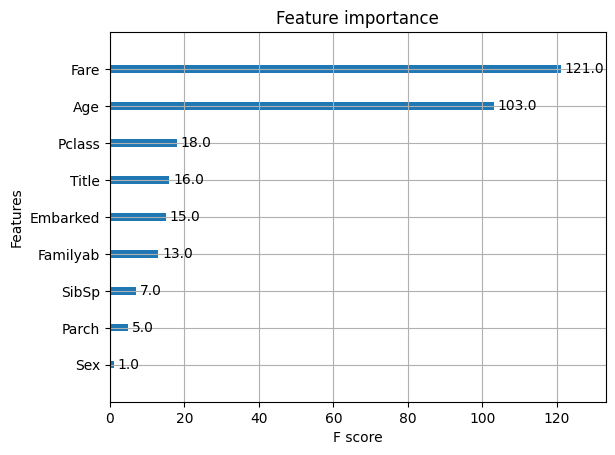

In [139]:
#目前最优val_acc=0.8439959826752871
xgb_model = xgb.XGBClassifier(n_estimators=8,max_depth=10,min_child_weight=3,reg_lambda=0,random_state=0)
xgb_model.fit(train_data, train_val_y)
plot_importance(xgb_model)
plt.show()

In [116]:
y_pred = xgb_model.predict(test_data)
y_pred

array([0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1,
       1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0,
       1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1,
       0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1,
       0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,

In [63]:
#产出结果datframe
output=pd.DataFrame({"index":test_data1["PassengerId"].index,"PassengerId":test_data1["PassengerId"].values})
output["Survived"]=y_pred
output.drop(columns="index",inplace=True)
output.head()


,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0


In [64]:
output.to_csv("output_XGBoost.csv",index=None)